In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [122]:
from antifold.antiscripts import IMGT_dict
import logomaker
import warnings


def plot_df_csv_logo(
    pdb_name: str,
    df_csv: "pd.DataFrame",
    out_dir: str,
    region_str_list: list = ["CDR1", "CDR2", "CDR3"],
    IMGT_dict: dict = IMGT_dict,
) -> None:
    """Plots residue probabilities for each region in df_csv"""

    amino_list = list("ACDEFGHIKLMNPQRSTVWY")

    df_proc = df_csv.copy()
    df_proc.index = df_proc["pdb_posins"]

    # Extract relevant positions
    region_list = [list(IMGT_dict[key]) for key in region_str_list]

    # Split into H/L chains
    H, L = df_proc["pdb_chain"].unique()[0:2]
    for chain in [H, L]:
        # Relevant regions
        for region, region_str in zip(region_list, region_str_list):
            # H or L chain only
            df_chain = df_proc[df_proc["pdb_chain"] == chain]

            # Probabilities for this region only
            selected_region = df_chain[df_chain["pdb_pos"].isin(region)]
            probs = selected_region[amino_list]

            # Log-probs to probs
            probs = np.e ** (probs)

            # Sum to 1
            probs[:] = probs.values / probs.sum(axis=1).values.reshape(-1, 1)

            ## Plot
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                # Probability matrix, 1-100 %
                ss_df = probs.copy()

                # Custom x-ticks for posins
                x_ticks = ss_df.index
                x_ticks = [
                    f"{posin[:-1]}\n   {posin[-1]}" if posin[-1].isalpha() else posin
                    for posin in ss_df.index
                ]
                x_ticks = [str(i) for i in x_ticks]
                ss_df.index = np.arange(0, len(ss_df))

                # Plot with custom width
                width = int(5 * len(ss_df) / 12.5)
                fig, ax = plt.subplots(1, 1, figsize=(width, 2.2))
                ss_logo = logomaker.Logo(
                    ss_df,
                    width=0.8,
                    vpad=0.05,
                    fade_probabilities=True,
                    stack_order="big_on_top",
                    color_scheme="chemistry",
                    ax=ax,
                )

                # Style using LOGO methods
                ss_logo.style_spines(spines=["left", "right"], visible=False)
                ss_logo.ax.set_ylabel("Probability")
                ss_logo.ax.set_xlabel("Position")

                # Custom x-tick labels
                ax.set_xticks(np.arange(0, len(ss_df)))
                ax.set_xticklabels(x_ticks, rotation=0)

                # Custom y-ticks as percentage
                ax.set_yticklabels([f"{int(i*100)}" for i in ax.get_yticks()])
                plt.title(f"{region_str}, chain {chain}")

                # Save
                outname = f"{pdb_name}_{chain}_{region_str}.png"
                outpath = f"{out_dir}/{outname}"

                # plt.tight_layout()
                print(f"Saving probability plot to {outpath}")
                plt.savefig(outpath, bbox_inches="tight", dpi=300)

Saving probability plot to ../_temp/output/1A2Y_H_CDR1.png
Saving probability plot to ../_temp/output/1A2Y_H_CDR2.png
Saving probability plot to ../_temp/output/1A2Y_H_CDR3.png
Saving probability plot to ../_temp/output/1A2Y_L_CDR1.png
Saving probability plot to ../_temp/output/1A2Y_L_CDR2.png
Saving probability plot to ../_temp/output/1A2Y_L_CDR3.png


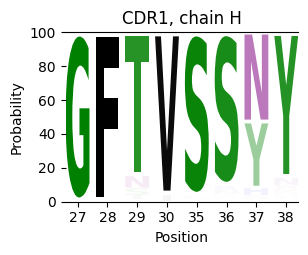

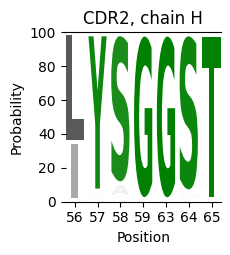

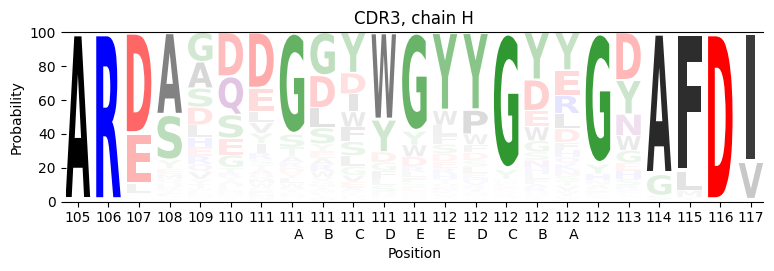

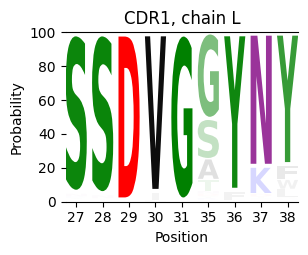

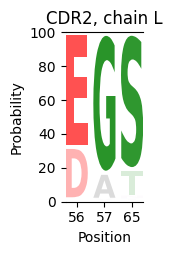

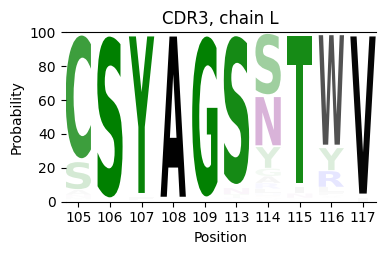

In [123]:
# Load CSV
df_csv = pd.read_csv("../output/example_pdbs/C143_immunebuilder.csv")

# Input args
pdb_name = "1A2Y"
out_dir = "../_temp/output"
region_str_list = ["CDR1", "CDR2", "CDR3"]

# Plot and save
plot_df_csv_logo(
    pdb_name=pdb_name, df_csv=df_csv, out_dir=out_dir, region_str_list=region_str_list
)